In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

import random
import os
import cv2
from IPython.display import Image
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3

import pandas as pd
import seaborn as sns

In [2]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [3]:
#path of image folders
train = 'dataset/train'
test = 'dataset/test'

train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train,target_size=(150,150),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = test_datagen.flow_from_directory(test,target_size=(150,150),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=True)


Found 519 images belonging to 2 classes.
Found 106 images belonging to 2 classes.


In [4]:
tf.keras.backend.clear_session()
inception_epoch = 60

from keras import Model, layers
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D


In [7]:


class_dict = train_generator.class_indices
print(class_dict)
class_dict = {values:key for key,values in class_dict.items()}
print(class_dict)

#convert dictionary to list
class_list = [values for _,values in class_dict.items()]
print(class_list)



{'disease': 0, 'nondisease': 1}
{0: 'disease', 1: 'nondisease'}
['disease', 'nondisease']


In [9]:
InceptionV3_model = InceptionV3(input_shape=(150,150,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(2, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data =test_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

 

Epoch 1/60
17/17 [==============================] - 137s 8s/step - loss: 0.8170 - accuracy: 0.5954 - val_loss: 1.0961 - val_accuracy: 0.5377
Epoch 2/60
17/17 [==============================] - 131s 8s/step - loss: 0.6590 - accuracy: 0.6763 - val_loss: 0.9553 - val_accuracy: 0.5660
Epoch 3/60
17/17 [==============================] - 131s 8s/step - loss: 0.5621 - accuracy: 0.7592 - val_loss: 0.9608 - val_accuracy: 0.6038
Epoch 4/60
17/17 [==============================] - 131s 8s/step - loss: 0.5394 - accuracy: 0.7418 - val_loss: 1.1361 - val_accuracy: 0.5660
Epoch 5/60
17/17 [==============================] - 131s 8s/step - loss: 0.4369 - accuracy: 0.8112 - val_loss: 1.0498 - val_accuracy: 0.5566
Epoch 6/60
17/17 [==============================] - 131s 8s/step - loss: 0.4053 - accuracy: 0.8227 - val_loss: 0.9054 - val_accuracy: 0.5660
Epoch 7/60
17/17 [==============================] - 131s 8s/step - loss: 0.3810 - accuracy: 0.8343 - val_loss: 0.9736 - val_accuracy: 0.5566
Epoch 8/60
17

17/17 [==============================] - 130s 8s/step - loss: 0.1454 - accuracy: 0.9403 - val_loss: 0.8361 - val_accuracy: 0.5755
Epoch 29/60
17/17 [==============================] - 130s 8s/step - loss: 0.1526 - accuracy: 0.9364 - val_loss: 0.9168 - val_accuracy: 0.5660
Epoch 30/60
17/17 [==============================] - 130s 8s/step - loss: 0.1863 - accuracy: 0.9152 - val_loss: 0.7592 - val_accuracy: 0.6038
Epoch 31/60
17/17 [==============================] - 130s 8s/step - loss: 0.1452 - accuracy: 0.9595 - val_loss: 0.8151 - val_accuracy: 0.5755
Epoch 32/60
17/17 [==============================] - 130s 8s/step - loss: 0.1574 - accuracy: 0.9345 - val_loss: 0.8484 - val_accuracy: 0.5755


C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


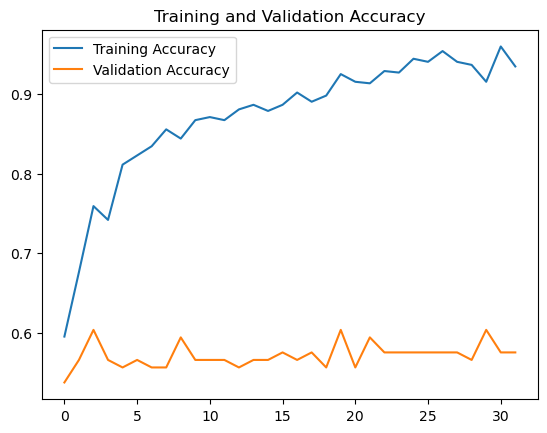

<Figure size 640x480 with 0 Axes>

C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ashwi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


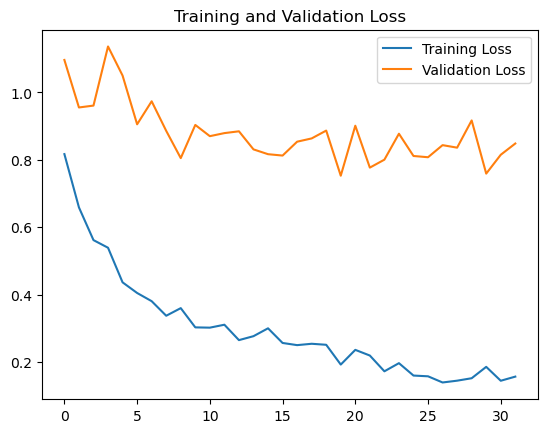

<Figure size 640x480 with 0 Axes>

In [10]:
do_history_stuff(inceptionv3_history, 'inceptionv3_model', True) 

In [11]:
InceptionV3_x_final_model.save("InceptionModel.h5")

In [16]:
inception_best_model = InceptionV3_x_final_model 

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
inception_pred = []

for folder in os.listdir(test):
    
    test_image_ids = os.listdir(os.path.join(test,folder))
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test,folder,image_id)
        
        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
       
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        

1/1 [==============================] - 0s 44ms/step


In [18]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.6037735849056604
              precision    recall  f1-score   support

     disease       0.60      0.77      0.68        57
  nondisease       0.61      0.41      0.49        49

    accuracy                           0.60       106
   macro avg       0.60      0.59      0.58       106
weighted avg       0.60      0.60      0.59       106



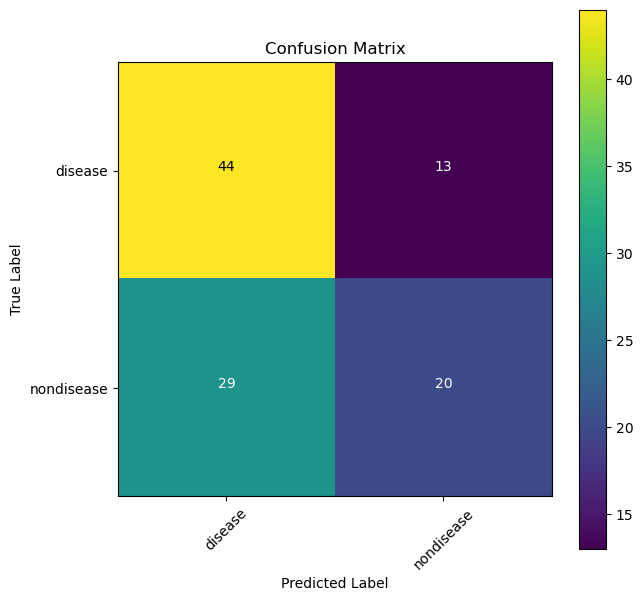

In [19]:
# Inception model classification report
clf_report(true_value, inception_pred)